In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm
#tqdm.pandas(desc='pandas bar')
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import Word2Vec
import gc
import time

#nlp
import re, string
import nltk

#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

#lightgbm
import lightgbm as lgb

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

C:\Users\whtwht97\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\whtwht97\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning:

pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\whtwht97\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning:

pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



<Figure size 432x288 with 0 Axes>

In [24]:
train = pd.read_csv('C:/Users/whtwht97/Desktop/Document/UChicago/Q2 - Health Analytics/final proj/drugsComTrain_raw.csv')
test = pd.read_csv('C:/Users/whtwht97/Desktop/Document/UChicago/Q2 - Health Analytics/final proj/drugsComTest_raw.csv')
df = pd.concat([train,test])
df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


In [25]:
df["rating"] = df["rating"].astype("int32")
df["usefulCount"] = df["usefulCount"].astype("int32")

In [26]:
# check missing values 
df.isnull().sum()/len(df) * 100

uniqueID       0.000000
drugName       0.000000
condition      0.555186
review         0.000000
rating         0.000000
date           0.000000
usefulCount    0.000000
dtype: float64

In [27]:
# condition column only 0.55% percent missing values, we can drop it
df = df.dropna()

In [28]:
# sort the dataframe by uniqueID
df = df.sort_values("uniqueID").reset_index(drop=True)

In [29]:
df.drugName.value_counts().sort_values()

Lincocin                                1
Tandem DHA                              1
Femtrace                                1
Mumps virus vaccine                     1
Cometriq                                1
                                     ... 
Ethinyl estradiol / norgestimate     2682
Nexplanon                            2892
Ethinyl estradiol / norethindrone    3619
Etonogestrel                         4402
Levonorgestrel                       4896
Name: drugName, Length: 3667, dtype: int64

In [30]:
df.condition.value_counts().sort_values()

Sporotrichosis                                     1
37</span> users found this comment helpful.        1
ungal Infection Prophylaxis                        1
Pertussis Prophylaxis                              1
Short Stature                                      1
                                               ...  
Acne                                            7435
Anxiety                                         7812
Pain                                            8245
Depression                                     12164
Birth Control                                  38436
Name: condition, Length: 916, dtype: int64

In [31]:
# there are a lot of duplicated reviews due to different drug name alias
df[df.duplicated(["review"])]

,uniqueID,drugName,condition,review,rating,date,usefulCount
421,459,Medroxyprogesterone,Amenorrhea,"""I have always had amenorrhea (irregular perio...",9,5-May-15,18
1673,1816,Zolmitriptan,Migraine,"""Fantastic. I use to suffer with nasty migrane...",9,21-Mar-08,7
2471,2700,Diltiazem,Atrial Fibrillation,"""I was happy with medication, as I did not hav...",5,27-Jul-13,50
2474,2704,Diltiazem,Supraventricular Tachycardia,"""I am on 240 mg once a day, Been taking meds s...",6,1-Oct-12,45
2479,2710,Diltiazem,Atrial Flutte,"""I have been diagnosed for 3 years with tachyc...",3,10-Nov-11,36
...,...,...,...,...,...,...,...
213857,232277,Amoxicillin / clavulanate,Bacterial Infection,"""I started Augmentin on Thursday morning becau...",2,23-Jul-17,7
213862,232283,Amoxicillin / clavulanate,Sinusitis,"""I will never take this drug again. I was pres...",1,2-Jul-17,16
213863,232284,Amoxicillin / clavulanate,Bacterial Infection,"""I was prescribed augmentin for a dental infec...",7,2-Jul-17,4
213864,232286,Amoxicillin / clavulanate,Sinusitis,"""Don&#039;t ever use this, \r\nWhen I was 4 ye...",1,29-Jun-17,8


In [32]:
# an example: Cefixime and Suprax are actually the same drug, just alias.
df[df["review"].str.contains("This drug got me well when NOTHING else would")]

,uniqueID,drugName,condition,review,rating,date,usefulCount
2570,2817,Cefixime,Sinusitis,"""This drug got me well when NOTHING else would...",10,25-Jul-16,3
3529,3855,Suprax,Sinusitis,"""This drug got me well when NOTHING else would...",10,25-Jul-16,3


In [33]:
# drop duplicated texts 
df.drop_duplicates(subset=["review"],inplace=True)

In [34]:
df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4
1,2,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10,27-Oct-15,11
2,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7
3,4,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9,26-Oct-15,12
4,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,25-Oct-15,4
...,...,...,...,...,...,...,...
213860,232281,Amoxicillin / clavulanate,Sinusitis,"""I have my 5th sinus infection of the year (20...",9,9-Jul-17,15
213861,232282,Amoxicillin / clavulanate,Otitis Media,"""I&#039;m not sure if I&#039;m the only one wi...",1,5-Jul-17,1
213865,232288,Amoxicillin / clavulanate,Sinusitis,"""For acute maxillary sinusitis. Day two, just ...",9,21-Jun-17,14
213866,232289,Amoxicillin / clavulanate,Urinary Tract Infection,"""I took Amox Clav 2x day for 7 days for my uri...",4,17-Jun-17,2


In [35]:
df[df["condition"].str.contains("</span>")]["condition"] 

1353      11</span> users found this comment helpful.
1362      44</span> users found this comment helpful.
1542      46</span> users found this comment helpful.
2249      12</span> users found this comment helpful.
2344       2</span> users found this comment helpful.
                             ...                     
212436     3</span> users found this comment helpful.
212485    37</span> users found this comment helpful.
212499    29</span> users found this comment helpful.
212867     5</span> users found this comment helpful.
213678    10</span> users found this comment helpful.
Name: condition, Length: 1166, dtype: object

In [36]:
# these 1171 rows have wrong condition info, but the reviews are still useful.
df[df["condition"].str.contains("</span>")]["condition"] = "Not Listed / Othe"

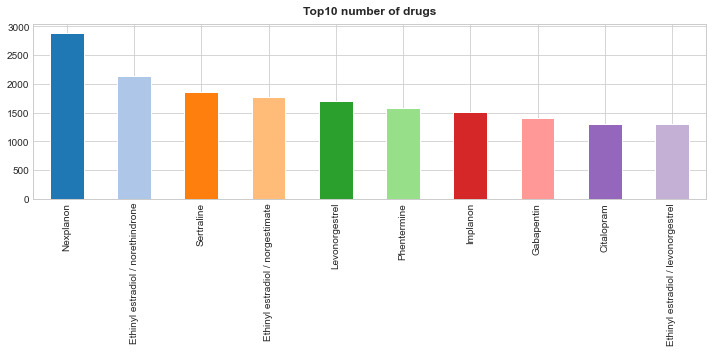

In [37]:
# top 10 number of drugs 
condition_num = df.drugName.value_counts().sort_values(ascending=False)
condition_num[:10].plot(kind="bar", figsize = (10,5), color=sns.color_palette("tab20"));
plt.title("Top10 number of drugs");

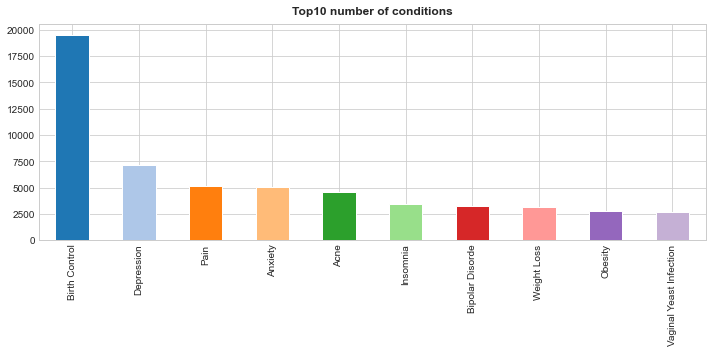

In [38]:
# top 10 number of conditions
condition_num = df.condition.value_counts().sort_values(ascending=False)
condition_num[:10].plot(kind="bar", figsize = (10,5), color=sns.color_palette("tab20"));
plt.title("Top10 number of conditions");

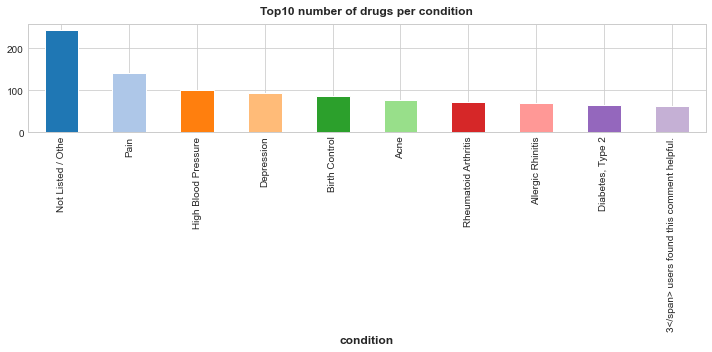

In [39]:
# top 10 number of drugs per each condtion
condition_per_condtion = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_per_condtion[0:10].plot(kind="bar", figsize = (10,5), color=sns.color_palette("tab20"));
plt.title("Top10 number of drugs per condition");

In [40]:
# Create a list of all drugs and their average ratings, cast to dataframe
rate_ls = []

for i in df.drugName.unique():
    
    # Only consider drugs that have at least 10 ratings
    if np.sum(df.drugName == i) >= 10:
        rate_ls.append((i, np.sum(df[df.drugName == i].rating) / np.sum(df.drugName == i)))
    
avg_rate = pd.DataFrame(rate_ls)

In [41]:
# Sort drugs by their ratings, look at top 10 best and worst rated drugs
avg_rate = avg_rate.sort_values(by=[1], ascending=False).reset_index(drop=True)
avg_rate[:10]

,0,1
0,Privine,10.000000
1,Zutripro,10.000000
2,Drixoral Cold and Allergy,9.956522
3,Emend,9.916667
4,Silver sulfadiazine,9.808511
5,Tegaserod,9.772727
6,Loperamide,9.769231
7,Esterified estrogens / methyltestosterone,9.692308
8,Desoxyn,9.666667
9,Aspirin / butalbital / caffeine / codeine,9.652174


In [42]:
avg_rate[-10:]

,0,1
977,Belbuca,3.510204
978,Trimethoprim,3.500000
979,Brimonidine,3.425743
980,Delsym,3.375000
981,Visine Totality Multi-Symptom Relief,3.300000
982,Hydralazine,3.052632
983,Miconazole,2.924071
984,Rhofade,2.818182
985,Alendronate,2.689655
986,Systane,2.090909


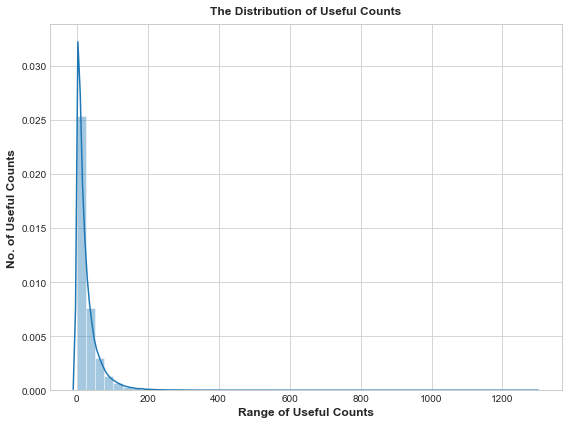

In [43]:
# plotting a dist plot
plt.rcParams['figure.figsize'] = (8, 6)
sns.distplot(df['usefulCount'])
plt.title('The Distribution of Useful Counts')
plt.xlabel('Range of Useful Counts')
plt.ylabel('No. of Useful Counts')
plt.show()

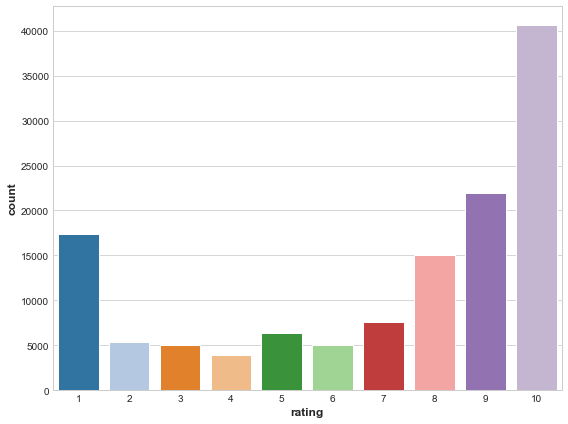

In [44]:
plt.rcParams['figure.figsize'] = [8,6]
sns.countplot(data=df,x="rating",palette="tab20");

In [45]:
df.loc[:,"sentiment"] = ""
df.loc[df["rating"].isin([7,8,9,10]),"sentiment"] = 2
df.loc[df["rating"].isin([1,2,3]),"sentiment"] = 0
df.loc[df["rating"].isin([4,5,6]),"sentiment"] = 1

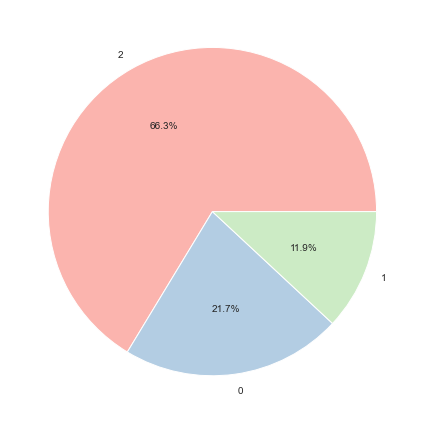

In [46]:
label = df.sentiment.value_counts().index
sizes = df.sentiment.value_counts().values
plt.pie(x=sizes, labels=label,colors=sns.color_palette("Pastel1"), autopct="%1.1f%%");

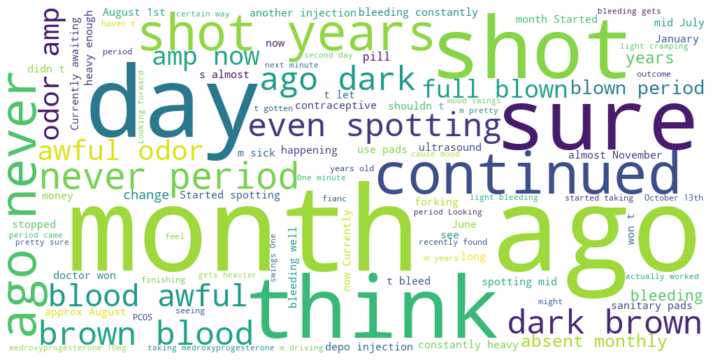

In [47]:
# Word cloud of the all reviews

from wordcloud import WordCloud
df_all = df.loc[df.sentiment , 'review']
k = (' '.join(df_all))

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(k)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [48]:

from nltk.tokenize import sent_tokenize # tokenizes sentences
from nltk.stem import PorterStemmer     # parsing/stemmer
from nltk.tag import pos_tag            # parts-of-speech tagging
from nltk.corpus import wordnet         # sentiment scores
from nltk.stem import WordNetLemmatizer # stem and context
from nltk.corpus import stopwords       # stopwords
from nltk.util import ngrams            # ngram iterator
from nltk.tokenize import word_tokenize


# import word2vec
from gensim.test.utils import datapath
from gensim import utils
from gensim.models import Word2Vec

# import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bs4 import BeautifulSoup
import nltk
import re

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

In [49]:
ps = PorterStemmer()
wnl = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))


def review_cleaner(review, lemmatize=True, stem=False):
    '''
        Clean and preprocess a review.
            1. Remove HTML tags
            2. Extract emoticons
            3. Use regex to remove all special characters (only keep letters)
            4. Make strings to lower case and tokenize / word split reviews
            5. Remove English stopwords
            6. Lemmatize
            7. Rejoin to one string
        
        @review (type:str) is an unprocessed review string
        @return (type:str) is a 6-step preprocessed review string
    '''
    if lemmatize == True and stem == True:
        raise RuntimeError("May not pass both lemmatize and stem flags")

    #1. Remove HTML tags
    review = BeautifulSoup(review, "lxml").text

    #2. Use regex to find emoticons
    pattern2 ='(?::|;|=)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(pattern2,review)

    #3. Remove punctuation
    pattern3 = r"[^\w+ \d+]"
    review = re.sub(pattern3, "",review)

    #4. Tokenize into words (all lower case)
    review = review.lower()

    #5. Remove stopwords, Lemmatize, Stem
        
    word_tokens = word_tokenize(review)
    filtered_sentence = [w for w in word_tokens if not w in eng_stopwords]
    filtered_sentence = []
    for w in word_tokens:
         if w not in eng_stopwords:               
                w = wnl.lemmatize(w)              
                filtered_sentence.append(w)
                
    
    #6. Join the review to one sentence
    filtered_sentence = " ".join(filtered_sentence+emoticons)        
    
    return filtered_sentence


In [50]:
%time df['review_clean'] = df['review'].apply(review_cleaner)

Wall time: 1min 58s


In [51]:
df = df[['uniqueID','review_clean','sentiment','rating']]

In [52]:
result = []
for text in df.review_clean:
        temp = len(text.split())
        result.append(temp)
        
df["text_len"] = result
df["text_len"]

0         51
1         63
2         29
3         67
4         70
          ..
213860    59
213861    36
213865    19
213866    51
213867    83
Name: text_len, Length: 128449, dtype: int64

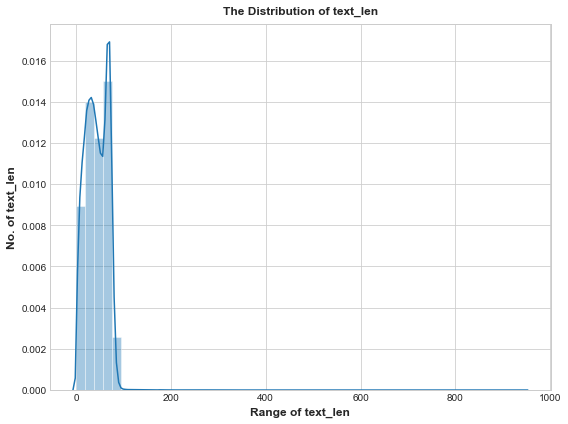

In [53]:
# plotting a dist plot of text length
plt.rcParams['figure.figsize'] = (8, 6)
sns.distplot(df['text_len'])
plt.title('The Distribution of text_len')
plt.xlabel('Range of text_len')
plt.ylabel('No. of text_len')
plt.show()

In [54]:
from collections import defaultdict
df_positive = df[df["rating"].isin([7,8,9,10])]
df_neutral = df[df["rating"].isin([4,5,6])]
df_negative = df[df["rating"].isin([1,2,3])]

In [55]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in eng_stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [56]:
# !pip install chart-studio

In [57]:
from collections import defaultdict
import plotly.graph_objects as go
from chart_studio import plotly
from plotly import tools
from plotly.subplots import make_subplots
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import iplot

freq_dict = defaultdict(int)
for sent in df_negative["review_clean"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df_neutral["review_clean"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df_positive["review_clean"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace3 = horizontal_bar_chart(fd_sorted.head(50), 'red')


In [58]:
import plotly.graph_objects as go
from chart_studio import plotly
from plotly import tools
from plotly.subplots import make_subplots
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import iplot

In [59]:
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent 4-grams of negative", 
                                          "Frequent 4-grams of neutral",
                                          "Frequent 4-grams of positive"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="4-grams Count Plots")
fig.show()